In [1]:
import os
import sys
from dotenv import load_dotenv
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from tqdm import tqdm

load_dotenv()

sys.path.append(os.path.abspath(os.path.join("..")))
from src.captchadataset import CaptchaDataset  # noqa: E402

In [2]:
captcha_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomInvert(p=0.5),
        transforms.ToTensor(),
    ]
)
dataset = CaptchaDataset(os.environ["DATA_ROOT_DIR"], transform=captcha_transformation)

In [3]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_size, val_size, test_size

(90449, 11306, 11307)

In [4]:
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class CaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(CaptchaModel, self).__init__()
        # CNN to extract features
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 50 -> 25
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 25 -> 12
        )

        # RNN to handle the sequence
        # The input size here depends on your image width after convolutions
        self.lstm = nn.LSTM(
            input_size=640, hidden_size=128, bidirectional=True, batch_first=True
        )

        self.classifier = nn.Linear(256, num_chars)

    def forward(self, x):
        x = self.conv_layer(x)
        # Reshape for LSTM: (Batch, Channels, Height, Width) -> (Batch, Width, Features)
        x = x.permute(0, 3, 1, 2)
        batch, width, channels, height = x.size()
        x = x.view(batch, width, -1)

        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x


# Initialize
model = CaptchaModel(num_chars=len(dataset.vocab) + 1)  # Add Blank Character

In [12]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    ctc_loss = nn.CTCLoss(blank=0)  # 0 is usually reserved for the 'blank' character
    total_loss = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # 1. Forward pass
        # model output shape: [Batch, Time_Steps, Num_Chars]
        logits = model(images)

        # 2. Prepare for CTC (CTC expects [Time_Steps, Batch, Num_Chars])
        logits = logits.permute(1, 0, 2)
        log_probs = nn.functional.log_softmax(logits, dim=2)

        # 3. Create lengths tensors
        batch_size = images.size(0)
        input_lengths = torch.full(
            (batch_size,), log_probs.size(0), dtype=torch.long
        ).to(device)
        target_lengths = torch.full((batch_size,), labels.size(1), dtype=torch.long).to(
            device
        )

        # 4. Calculate Loss
        loss = ctc_loss(log_probs, labels, input_lengths, target_lengths)

        # 5. Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [13]:
def validate(model, dataloader, device):
    model.eval()
    ctc_loss = nn.CTCLoss(blank=0)
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images).permute(1, 0, 2)
            log_probs = nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.full(
                (batch_size,), log_probs.size(0), dtype=torch.long
            ).to(device)
            target_lengths = torch.full(
                (batch_size,), labels.size(1), dtype=torch.long
            ).to(device)

            loss = ctc_loss(log_probs, labels, input_lengths, target_lengths)
            val_loss += loss.item()

    return val_loss / len(dataloader)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Training:   0%|          | 0/2827 [00:00<?, ?it/s]

Training: 100%|██████████| 2827/2827 [15:00<00:00,  3.14it/s]


Epoch 1/20
Train Loss: 4.3427 | Val Loss: 4.1727


Training: 100%|██████████| 2827/2827 [01:27<00:00, 32.25it/s]


Epoch 2/20
Train Loss: 3.9581 | Val Loss: 3.6169


Training: 100%|██████████| 2827/2827 [01:29<00:00, 31.63it/s]


Epoch 3/20
Train Loss: 3.2168 | Val Loss: 2.9104


Training: 100%|██████████| 2827/2827 [01:36<00:00, 29.35it/s]


Epoch 4/20
Train Loss: 2.5273 | Val Loss: 2.2800


Training: 100%|██████████| 2827/2827 [01:32<00:00, 30.52it/s]


Epoch 5/20
Train Loss: 2.0659 | Val Loss: 1.9731


Training: 100%|██████████| 2827/2827 [01:38<00:00, 28.68it/s]


Epoch 6/20
Train Loss: 1.7595 | Val Loss: 1.6673


Training: 100%|██████████| 2827/2827 [01:42<00:00, 27.65it/s]


Epoch 7/20
Train Loss: 1.5228 | Val Loss: 1.4608


Training: 100%|██████████| 2827/2827 [01:33<00:00, 30.24it/s]


Epoch 8/20
Train Loss: 1.3352 | Val Loss: 1.2931


Training: 100%|██████████| 2827/2827 [01:34<00:00, 30.03it/s]


Epoch 9/20
Train Loss: 1.1923 | Val Loss: 1.1908


Training: 100%|██████████| 2827/2827 [01:33<00:00, 30.22it/s]


Epoch 10/20
Train Loss: 1.0803 | Val Loss: 1.0790


Training: 100%|██████████| 2827/2827 [01:34<00:00, 29.83it/s]


Epoch 11/20
Train Loss: 0.9931 | Val Loss: 1.0438


Training: 100%|██████████| 2827/2827 [01:40<00:00, 28.21it/s]


Epoch 12/20
Train Loss: 0.9115 | Val Loss: 0.9828


Training: 100%|██████████| 2827/2827 [01:35<00:00, 29.49it/s]


Epoch 13/20
Train Loss: 0.8404 | Val Loss: 0.9111


Training: 100%|██████████| 2827/2827 [01:34<00:00, 29.94it/s]


Epoch 14/20
Train Loss: 0.7772 | Val Loss: 0.8589


Training: 100%|██████████| 2827/2827 [01:33<00:00, 30.20it/s]


Epoch 15/20
Train Loss: 0.7233 | Val Loss: 0.8302


Training: 100%|██████████| 2827/2827 [01:37<00:00, 29.14it/s]


Epoch 16/20
Train Loss: 0.6822 | Val Loss: 0.8331


Training: 100%|██████████| 2827/2827 [01:38<00:00, 28.73it/s]


Epoch 17/20
Train Loss: 0.6377 | Val Loss: 0.7750


Training: 100%|██████████| 2827/2827 [01:34<00:00, 29.83it/s]


Epoch 18/20
Train Loss: 0.6011 | Val Loss: 0.7573


Training: 100%|██████████| 2827/2827 [01:33<00:00, 30.26it/s]


Epoch 19/20
Train Loss: 0.6457 | Val Loss: 0.7618


Training: 100%|██████████| 2827/2827 [01:36<00:00, 29.33it/s]


Epoch 20/20
Train Loss: 0.5930 | Val Loss: 0.6999


In [15]:
torch.save(model.state_dict(), "crnn.pth")

In [16]:
def decode_predictions(logits, dataset):
    # logits shape: (Time_Steps, Num_Chars)
    # Get the index of the highest probability for each time step
    tokens = torch.argmax(logits, dim=-1)  # Shape: (Time_Steps)

    char_list = []
    for i in range(len(tokens)):
        token = tokens[i].item()

        # CTC Rules:
        # 1. Skip the blank token (index 0)
        # 2. Skip repeated tokens (if the model predicts 'aaaa', it's just 'a')
        if token != 0:
            if i > 0 and tokens[i] == tokens[i - 1]:
                continue
            char_list.append(dataset.idx_to_char[token])

    return "".join(char_list)

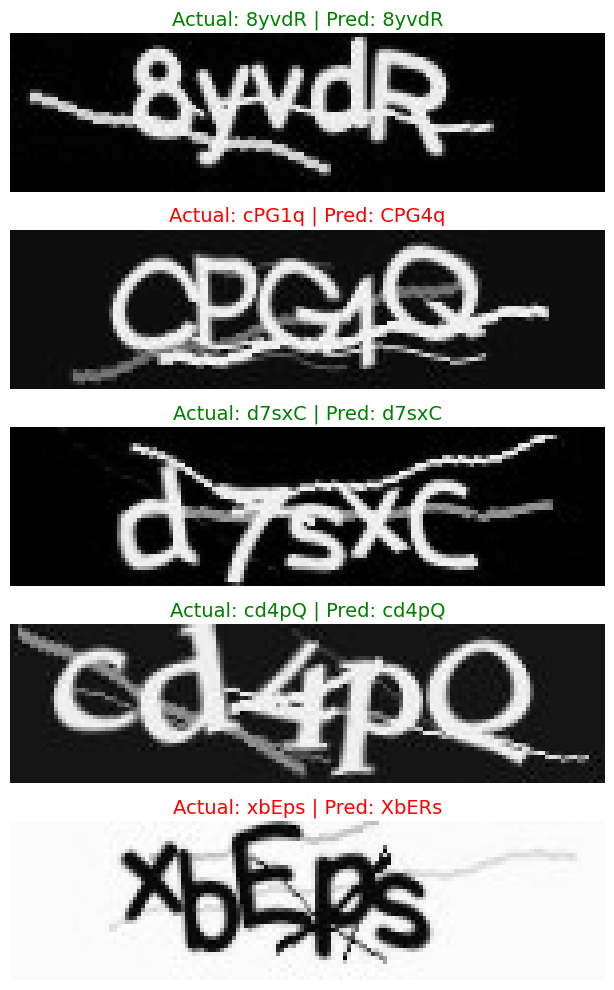

In [29]:
import matplotlib.pyplot as plt
import random


def visualize_predictions(model, dataloader, dataset, device, num_samples=5):
    model.eval()

    # 1. Get just ONE batch without loading the whole dataset
    # We use a loop that breaks immediately to grab the 'first' available batch
    # If your test_loader has shuffle=True, this will be a random batch.
    images, labels = next(iter(dataloader))

    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    plt.figure(figsize=(15, 10))

    batch_size = images.size(0)
    # Pick random indices within this single batch
    indices = random.sample(range(batch_size), min(num_samples, batch_size))

    for i, idx in enumerate(indices):
        img = images[idx].cpu().squeeze().numpy()
        pred_str = decode_predictions(logits[idx], dataset)
        actual_indices = [val.item() for val in labels[idx] if val.item() != 0]
        actual_str = "".join([dataset.idx_to_char[val] for val in actual_indices])

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img, cmap="gray")
        color = "green" if pred_str == actual_str else "red"
        plt.title(f"Actual: {actual_str} | Pred: {pred_str}", color=color, fontsize=14)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Usage:
visualize_predictions(model, test_loader, dataset, device)